In [81]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve,accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from ucimlrepo import fetch_ucirepo 

Logistic Regression helper functions

In [82]:
dataframe=None
X_train = None
X_test = None
y_train = None
y_test = None
X_val = None
y_val = None

class LogisticRegression:
    def __init__(self,maxIteration,noFeatures,learning_rate,lambda_param):
        self.maxIteration=maxIteration
        self.noFeatures=noFeatures
        self.theta = np.zeros((noFeatures,1))
        self.bias=0
        self.learning_rate=learning_rate
        self.lambda_param=lambda_param
        self.cost_history=[]

    def sigmoid(self,z):
        z = np.array(z, dtype=float)
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, X, y):
        m = len(y)
        predictions = X.dot(self.theta)
        cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)  # MSE
        l2_penalty = self.lambda_param * np.sum(self.theta ** 2)  # L2 regularization term
        return cost + l2_penalty

    def logisticRegression(self,X,y):
        m=len(X)
        for iteration in range(self.maxIteration):
            # matrix multiplication
            h = self.sigmoid(np.dot(X,self.theta)+self.bias)
            gradient = np.dot(X.T,(h - y))/m + (2 * self.lambda_param * self.theta)
            db=np.sum(h-y)/m
            self.theta -= self.learning_rate * gradient
            self.bias -= self.learning_rate * db
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)

    def predict(self,X):
        probabilities = self.sigmoid(np.dot(X,self.theta)+self.bias)
        predictions = [1 if prob >= 0.5 else 0 for prob in probabilities]
        return np.array(predictions)
    
    def output(self,X,predictions):
        y_test_np = y_test.flatten()

        # predictions = self.predict(X)
        # accuracy = np.mean(predictions == y_test_np)
        # print(f"Accuracy: {accuracy}")
        sensitivity = recall_score(y_test_np, predictions)
        print("Sensitivity/Recall: ", sensitivity)
        tn, fp, fn, tp = confusion_matrix(y_test_np, predictions).ravel()
        specificity = tn / (tn + fp)
        print("Specificity: ", specificity)
        precision = precision_score(y_test_np, predictions)
        print("Precision: ", precision)
        f1 = f1_score(y_test_np, predictions)
        print("F1 Score: ", f1)
        y_prob = self.sigmoid(np.dot(X,self.theta))
        auroc = roc_auc_score(y_test_np, y_prob)
        print("AUROC: ", auroc)
        precision_values, recall_values, _ = precision_recall_curve(y_test_np, y_prob)
        aupr = auc(recall_values, precision_values)
        print("AUPR: ", aupr)
    
    def train(self):
        self.logisticRegression(X_train,y_train)
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == y_test.flatten())
        print(f"Accuracy: {accuracy}")
        self.output(X_test,predictions)

def normalize(X):
    return (X - X.mean()) / X.std()



Stacking

In [83]:
def stacking(model_list,n_base_learners,learning_rate,maxIteration,noFeatures,lambda_param):
    global X_train,X_val,y_train,y_val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    # X_val = X_val.to_numpy()
    # y_val = y_val.to_numpy()
    meta_features = np.zeros((X_val.shape[0], n_base_learners))
    for i in range(n_base_learners):
        meta_features[:, i] = model_list[i].predict(X_val)
    # print(X_val.shape)
    # print(meta_features.shape)
    X=np.concatenate((X_val,meta_features),axis=1)
    # print(X.shape)

    LR_meta_final=LogisticRegression(maxIteration,X.shape[1],learning_rate,lambda_param)
    LR_meta_final.logisticRegression(X,y_val)
    meta_features_test = np.zeros((X_test.shape[0], n_base_learners))
    for i in range(n_base_learners):
        meta_features_test[:, i] = model_list[i].predict(X_test)

    X=np.concatenate((X_test,meta_features_test),axis=1)
    stacking_predictions = LR_meta_final.predict(X)
    stacking_accuracy = np.mean(stacking_predictions == y_test.flatten())

    print(f"Stacking Ensemble Accuracy: {stacking_accuracy}")
    LR_meta_final.output(X,stacking_predictions)

Majority voting

In [84]:
def majority_voting(model_list):
    predictions = np.zeros((len(model_list), X_test.shape[0]))

    for i, model in enumerate(model_list):
        predictions[i, :] = model.predict(X_test)

    final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)

    y_test_flattened = y_test.flatten()
    voting_accuracy = np.mean(final_predictions == y_test_flattened)
    print(f"Majority Voting Ensemble Accuracy: {voting_accuracy}")
    sensitivity = recall_score(y_test_flattened, final_predictions)
    print(f"Sensitivity/Recall: {sensitivity}")
    tn, fp, fn, tp = confusion_matrix(y_test_flattened, final_predictions).ravel()
    specificity = tn / (tn + fp)
    print(f"Specificity: {specificity}")
    precision = precision_score(y_test_flattened, final_predictions)
    print(f"Precision: {precision}")
    f1 = f1_score(y_test_flattened, final_predictions)
    print(f"F1 Score: {f1}")
    y_prob = np.mean([model.sigmoid(np.dot(X_test,model.theta)) for model in model_list], axis=0)  # Average the predicted probabilities
    auroc = roc_auc_score(y_test_flattened, y_prob)
    print(f"AUROC: {auroc}")
    precision_values, recall_values, _ = precision_recall_curve(y_test_flattened, y_prob)
    aupr = auc(recall_values, precision_values)
    print(f"AUPR: {aupr}")


Bagging

In [85]:
def bagging(n_base_learners,maxIteration,learning_rate,lambda_param):
    metrics_data = {
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "precision": [],
    "f1_score": [],
    "auroc": [],
    "aupr": []
    }
    model_list=[]
    noFeatures = X_train.shape[1]
    for i in range(n_base_learners):
        X_bootstrap, y_bootstrap = resample(X_train, y_train, random_state=i)
        
        LR=LogisticRegression(maxIteration,noFeatures,learning_rate,lambda_param)
        LR.logisticRegression(X_bootstrap,y_bootstrap)
        model_list.append(LR)

        predictions = LR.predict(X_test)
        accuracy = np.mean(predictions == y_test.flatten())
        # LR.output()
        model=model_list[-1]
        predictions = model.predict(X_test)
        y_test_flattened = y_test.flatten()
        accuracy = np.mean(predictions == y_test_flattened)
        metrics_data['accuracy'].append(accuracy)
        sensitivity = recall_score(y_test_flattened, predictions)
        metrics_data['sensitivity'].append(sensitivity)
        tn, fp, fn, tp = confusion_matrix(y_test_flattened, predictions).ravel()
        specificity = tn / (tn + fp)
        metrics_data['specificity'].append(specificity)
        precision = precision_score(y_test_flattened, predictions)
        metrics_data['precision'].append(precision)
        f1 = f1_score(y_test_flattened, predictions)
        metrics_data['f1_score'].append(f1)
        y_prob = model.sigmoid(np.dot(X_test,model.theta))
        auroc = roc_auc_score(y_test_flattened, y_prob)
        metrics_data['auroc'].append(auroc)
        precision_values, recall_values, _ = precision_recall_curve(y_test_flattened, y_prob)
        aupr = auc(recall_values, precision_values)
        metrics_data['aupr'].append(aupr)
    
    average_accuracy = np.mean(metrics_data['accuracy'])
    std_dev_accuracy = np.std(metrics_data['accuracy'])
    average_sensitivity = np.mean(metrics_data['sensitivity'])
    std_dev_sensitivity = np.std(metrics_data['sensitivity'])
    average_specificity = np.mean(metrics_data['specificity'])
    std_dev_specificity = np.std(metrics_data['specificity'])
    average_precision = np.mean(metrics_data['precision'])
    std_dev_precision = np.std(metrics_data['precision'])
    average_f1 = np.mean(metrics_data['f1_score'])
    std_dev_f1 = np.std(metrics_data['f1_score'])
    average_auc_roc = np.mean(metrics_data['auroc'])
    std_dev_auc_roc = np.std(metrics_data['auroc'])
    average_aupr = np.mean(metrics_data['aupr'])
    std_dev_aupr = np.std(metrics_data['aupr'])

    print(f"Bagging LR Learners - Accuracy: {average_accuracy:.4f} ± {std_dev_accuracy:.4f}")
    print(f"Sensitivity (Recall): {average_sensitivity:.4f} ± {std_dev_sensitivity:.4f}")
    print(f"Specificity: {average_specificity:.4f} ± {std_dev_specificity:.4f}")
    print(f"Precision: {average_precision:.4f} ± {std_dev_precision:.4f}")
    print(f"F1 Score: {average_f1:.4f} ± {std_dev_f1:.4f}")
    print(f"AUROC: {average_auc_roc:.4f} ± {std_dev_auc_roc:.4f}")
    print(f"AUPR: {average_aupr:.4f} ± {std_dev_aupr:.4f}")

    metrics_df = pd.DataFrame(metrics_data)
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics_data.keys()):
        plt.subplot(2, 4, i+1)  # 2 rows, 4 columns of subplots
        sns.violinplot(data=metrics_df[metric])
        plt.title(f'{metric.capitalize()} Violin Plot')

    plt.tight_layout()
    plt.show()
    stacking(model_list,n_base_learners,learning_rate,maxIteration,noFeatures,lambda_param)
    majority_voting(model_list)


Preprocessing

In [86]:
def scalingFunction(scaling='standard'):
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
    
    return scaler

def preprocessing(dataframe,target_col_name):
    # dataframe.replace(' ', np.nan, inplace=True)
    # dataframe.replace('?', np.nan, inplace=True)
    print(dataframe.isnull().sum())
    # drop null and fill null
    dataframe.dropna(subset=[target_col_name], inplace=True)
    dataframe.fillna(dataframe.mean(numeric_only=True),inplace=True)
    # fill null for non-numeric columns
    non_numerical_columns = dataframe.select_dtypes(include=['object']).columns
    for column in non_numerical_columns:
        mode_value = dataframe[column].mode()[0]
        dataframe[column].fillna(mode_value,inplace=True)
    print(dataframe.isnull().sum())
    # drop duplicates
    print(dataframe.duplicated().sum())
    dataframe.drop_duplicates(inplace=True)
    print(dataframe.duplicated().sum())
    # feature and target
    features=dataframe.drop(target_col_name,axis=1)
    target=dataframe[target_col_name]
    # label encoding the target
    encoder=LabelEncoder()
    target=encoder.fit_transform(target)
    # categorization and one-hot encoding
    categorical_columns=features.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        features[col]=features[col].astype('category')
    features=pd.get_dummies(features,columns=categorical_columns)
    print(features.dtypes)
    # print(target.shape)
    # scaling
    candidate_columns=features.select_dtypes(exclude=['bool']).columns
    scaler=scalingFunction('standard')
    # scaler=scalingFunction('minmax')
    features_scaled=features.copy()
    features_scaled[candidate_columns]=scaler.fit_transform(features[candidate_columns])
    return features_scaled,target



Information gain/Correlation analysis

In [87]:
def informationGain(n):
    global X_train,X_test
    mutual_info = mutual_info_classif(X_train, y_train)
    feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Information Gain': mutual_info
    })
    feature_importance = feature_importance.sort_values(by='Information Gain', ascending=False)
    # print(feature_importance)
    top_n_features = feature_importance['Feature'].head(n)
    X_train = X_train[top_n_features]
    X_test = X_test[top_n_features]

def correlationAnalysis(n,features,target):
    global X_train,X_test
    # features.reset_index(drop=True, inplace=True)
    # target.reset_index(drop=True, inplace=True)
    correlation=features.corrwith(target)
    print(correlation)
    top_n_features = correlation.abs().nlargest(n).index
    # print(top_n_features)
    # X_train=X_train[top_n_features]
    # X_test=X_test[top_n_features]
    features=features[top_n_features]
    # target=target[top_n_features]
    return features

Splitting datasets

In [88]:
def split(features, target):
    global X_train, X_test, y_train, y_test, X_val, y_val

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # X_train = X_train.to_numpy()
    # X_test = X_test.to_numpy()
    # y_train = y_train.to_numpy()
    # y_test = y_test.to_numpy()
    # X_val = X_val.to_numpy()
    # y_val = y_val.to_numpy()
def convertToNumpy():
    global X_train, X_test, y_train, y_test, X_val, y_val
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

Reading datasets

In [89]:
def read_2():
    global dataframe
    adult = fetch_ucirepo(id=2) 
    # data (as pandas dataframes) 
    X = adult.data.features 
    y = adult.data.targets
    y[y.columns[0]] = y[y.columns[0]].str.rstrip('.')
    dataframe=pd.concat([X, y], axis=1) 


def read(input):
    global dataframe
    # can I somehow assign the last column as target column
    target_col_name=None
    n_feature_selection=100
    # file 1
    if input == 1:
        dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
        target_col_name='Churn'
        dataframe['TotalCharges'] = dataframe['TotalCharges'].str.strip()
        dataframe['TotalCharges'].replace('', np.nan, inplace=True)
        dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'], errors='coerce')
    # file 2
    elif input == 2:
        read_2()
        target_col_name='income'
        dataframe.replace('?', np.nan, inplace=True)
    # file 3
    elif input == 3:
        dataframe = pd.read_csv('creditcard.csv')
        target_col_name='Class'
    else:
        print("Invalid input")
    features,target=preprocessing(dataframe,target_col_name)
    # print(dataframe.dtypes)
    features_df=pd.DataFrame(features,columns=features.columns)
    target_df=pd.DataFrame(target,columns=[target_col_name])
    target_series=target_df[target_col_name]
    features_df_normalized=normalize(features_df)
    features_df_normalized.reset_index(drop=True, inplace=True)
    target_df.reset_index(drop=True, inplace=True)

    # comment out the following 2 lines for information gain
    split(features_df_normalized,target_df)
    informationGain(n_feature_selection)


    # comment out the following 2 lines for correlation analysis
    # features_df_normalized=correlationAnalysis(n_feature_selection,features_df_normalized,target_series)
    # split(features_df_normalized,target_df)


    convertToNumpy()
    maxIteration=1000
    noFeatures=features_df.shape[1]
    learningRate=0.01
    n_base_learners=9
    lambda_param = 0.1
    LR=LogisticRegression(maxIteration,noFeatures,learningRate,lambda_param)
    # LR.train()
    bagging(n_base_learners,maxIteration,learningRate,lambda_param)


Input

C:\Users\hp\AppData\Local\Temp\ipykernel_12408\675281269.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y.columns[0]] = y[y.columns[0]].str.rstrip('.')
C:\Users\hp\AppData\Local\Temp\ipykernel_12408\977013730.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[column].f

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
53
0
age                               int64
fnlwgt                            int64
education-num                     int64
capital-gain                      int64
capital-loss                      int64
                                  ...  
native-country_Thailand            bool
native-country_Trinadad&Tobago     bool
nati

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bagging LR Learners - Accuracy: 0.8314 ± 0.0007
Sensitivity (Recall): 0.4730 ± 0.0054
Specificity: 0.9484 ± 0.0013
Precision: 0.7497 ± 0.0029
F1 Score: 0.5800 ± 0.0036
AUROC: 0.8893 ± 0.0002
AUPR: 0.7175 ± 0.0006


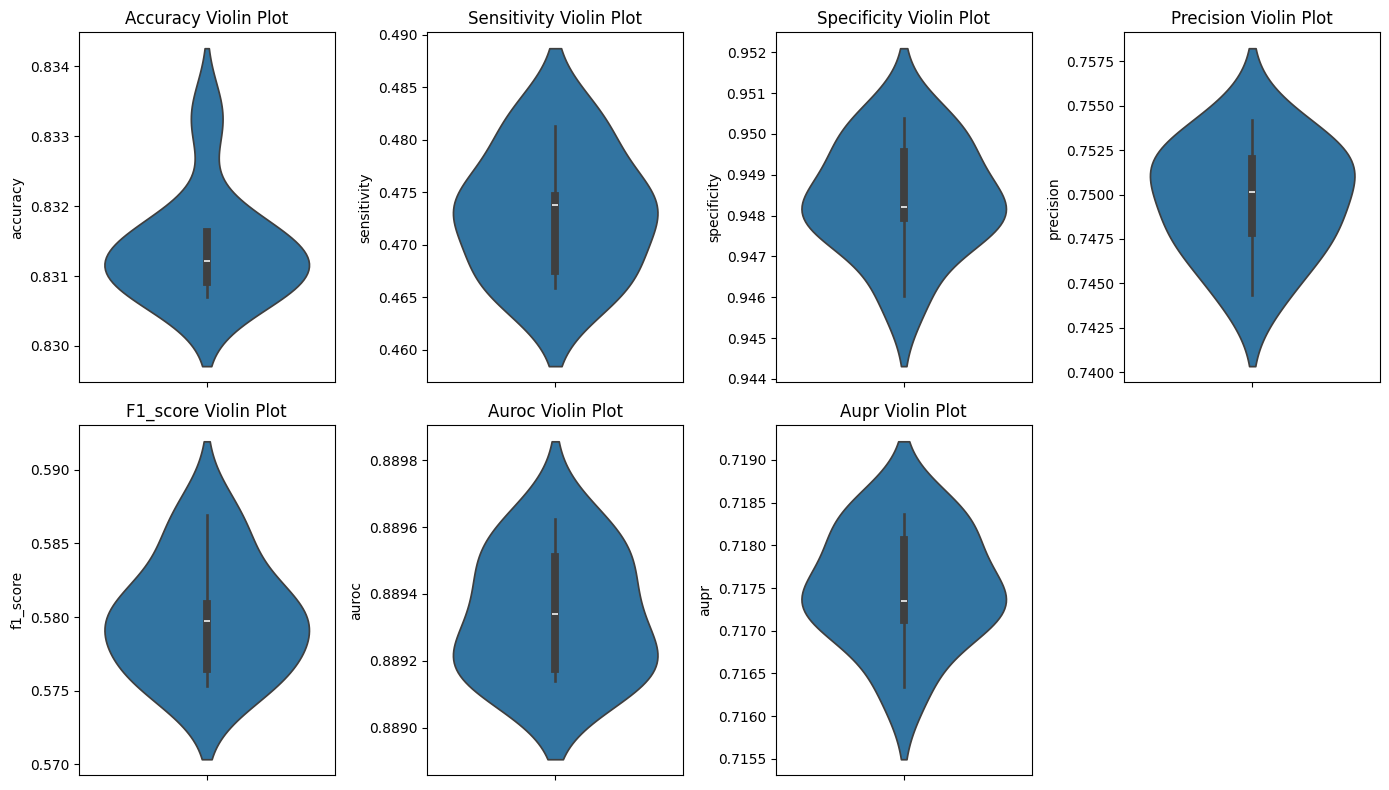

Stacking Ensemble Accuracy: 0.83172781307645
Sensitivity/Recall:  0.4750208159866778
Specificity:  0.9482055464926591
Precision:  0.7496714848883048
F1 Score:  0.5815494393476045
AUROC:  0.8892087502756223
AUPR:  0.715103469202064
Majority Voting Ensemble Accuracy: 0.8311129329780693
Sensitivity/Recall: 0.4733555370524563
Specificity: 0.9479336595976074
Precision: 0.7480263157894737
F1 Score: 0.5798062213156553
AUROC: 0.8896078082475226
AUPR: 0.7180201486494597


In [90]:
user_input = int(input("Enter 1, 2 or 3: "))
read(user_input)